In [1]:
import time
import math
import decimal
import pandas as pd
from pandas import DataFrame
from decimal import Decimal as dec
import seaborn as sns
import numpy as np
from numpy import random as np_rnd
import scipy
from scipy.stats.distributions import norm
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from IPython.display import Latex
import networkx as nx 

%matplotlib notebook

## Setup

In [2]:
EPSILON = 1e-3
BOUNDS = [-5, 5]

x_0 = [np_rnd.uniform(*BOUNDS) for _ in range(4)]

def y_k(f_x_k, delta_k):
    if f_x_k < -100:
        return -100 + delta_k
    elif f_x_k <= 100:
        return f_x_k + delta_k
    else:
        return 100 + delta_k
    
f_for_y = lambda x_k: 1 / (x_k * x_k - 3 * x_k + 2)
    

X = [k * 3 / 1000 for k in range(1001)]
delta = norm(loc=0, scale=1).rvs(size=1001)
Y = [y_k(f_for_y(x_k), delta[k]) for k, x_k in enumerate(X)]

def least_squares(x, *args):
    return sum([(args[0]([x[0], x[1], x[2], x[3]], x_k) - y_k) ** 2 for x_k, y_k in zip(X, Y)])

def least_squares_residuals(x, *args):
    return [(args[0]([x[0], x[1], x[2], x[3]], x_k) - y_k) for x_k, y_k in zip(X, Y)]



def F(x, *args):
    return (x[0] * args[0] + x[1]) / (args[0] * args[0] + x[2] * args[0] + x[3])

In [14]:
def visualize_curves(f, nm_res, lm_res, sa_res, de_res):
    x = np.linspace(-10, 10, 100)
    y_nm = [f(nm_res.x, x_i) for x_i in x]
    y_lm = [f(lm_res.x, x_i) for x_i in x]
    y_sa = [f(sa_res.x, x_i) for x_i in x]
    y_de = [f(de_res.x, x_i) for x_i in x]
    
    plot(np.linspace(-10, 10, 1001), Y, 'yo', label='Data')
    plot(x, y_nm, 'r.-', label="Nelder-Mead")
    plot(x, y_lm, 'g-', label="Levenberg-Marquardt")
    plot(x, y_sa, 'b--', label="Annealing")
    plot(x, y_de, 'y-.', label="Diff. ev.")
    plt.legend()

<IPython.core.display.Javascript object>


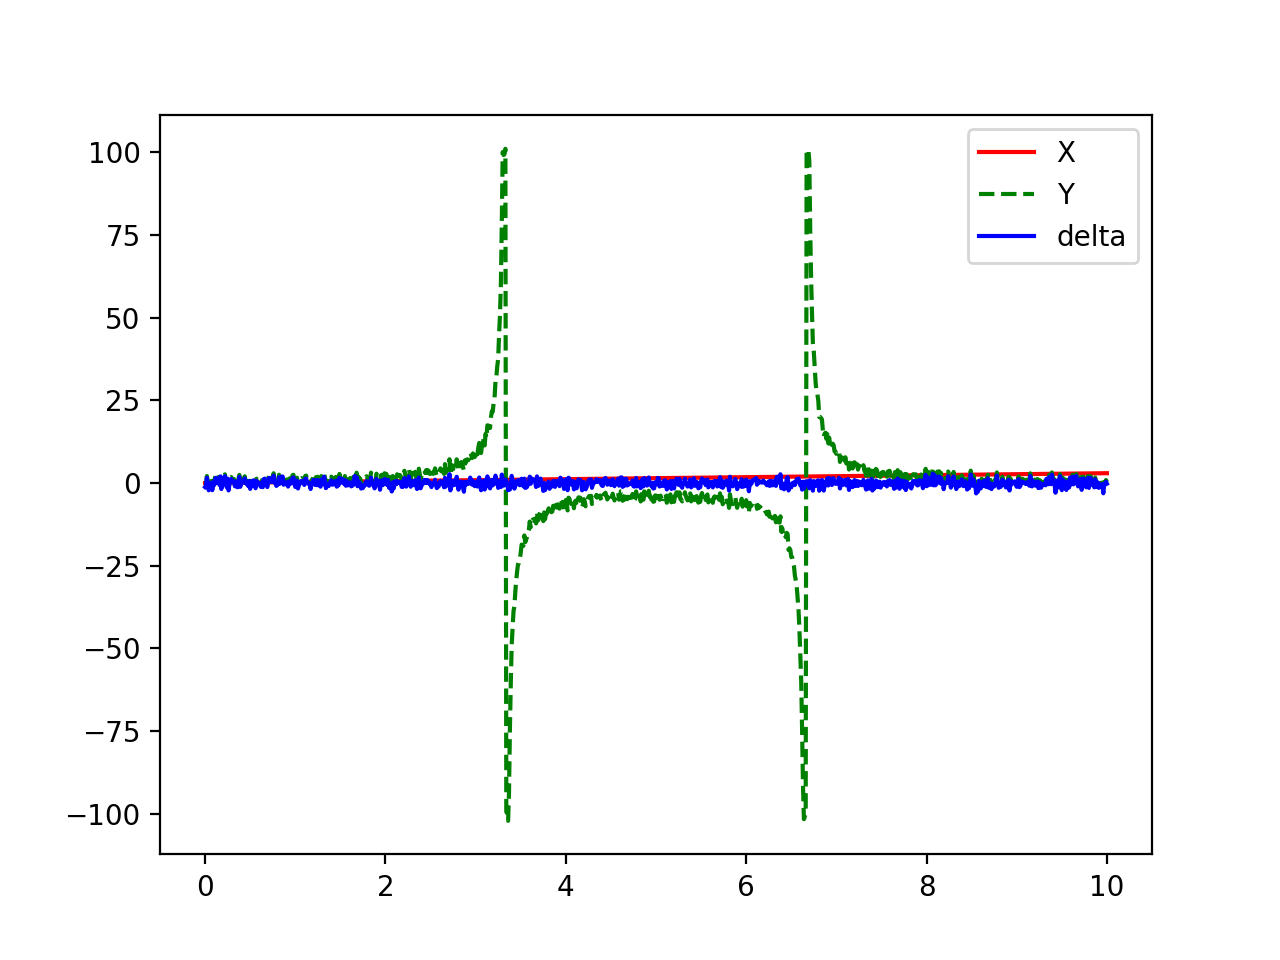

In [3]:
x = np.linspace(0, 10, 1001)
plot(x, X, 'r-', label='X')
plot(x, Y, 'g--', label='Y')
plot(x, delta, 'b-', label='delta')
plt.legend()

<IPython.core.display.Javascript object>


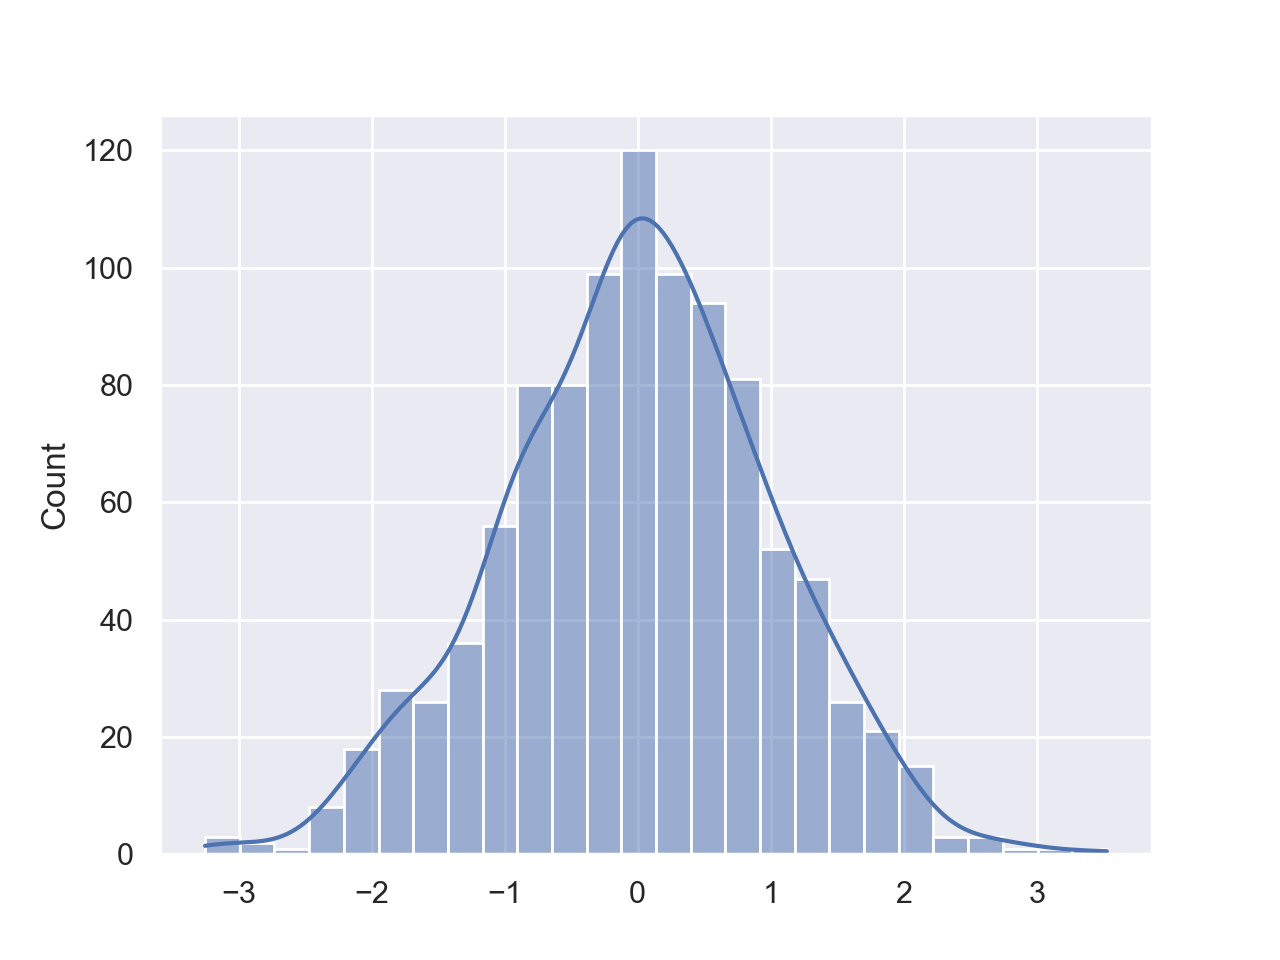

<AxesSubplot:ylabel='Count'>

In [4]:
sns.histplot(data=delta, kde=True)

In [4]:
nelder_mead_results = scipy.optimize.minimize(least_squares,\
                                              x0=[-1,1,-2,1],\
                                              args=(F), \
                                              method='Nelder-Mead',\
                                              tol=EPSILON,\
                                              options={'return_all': True})

In [5]:
levenberg_marquardt_results = scipy.optimize.least_squares(fun=least_squares_residuals,\
                                                           x0=[0,1,2,3],\
                                                           method='lm',\
                                                           xtol=EPSILON,\
                                                           args=([F]))

In [6]:
annealings = []
register_annealing = lambda x, f, state: annealings.append(x)
    
annealing_results = scipy.optimize.dual_annealing(least_squares,\
                                                 bounds = [BOUNDS for _ in range(4)],\
                                                 args=([F]),\
                                                 callback = register_annealing)

In [7]:
differential_evolution_results = scipy.optimize.differential_evolution(least_squares,\
                                                                       bounds = [BOUNDS for _ in range(4)],\
                                                                       args=([F]),\
                                                                       atol=EPSILON,\
                                                                       init='random')

<IPython.core.display.Javascript object>


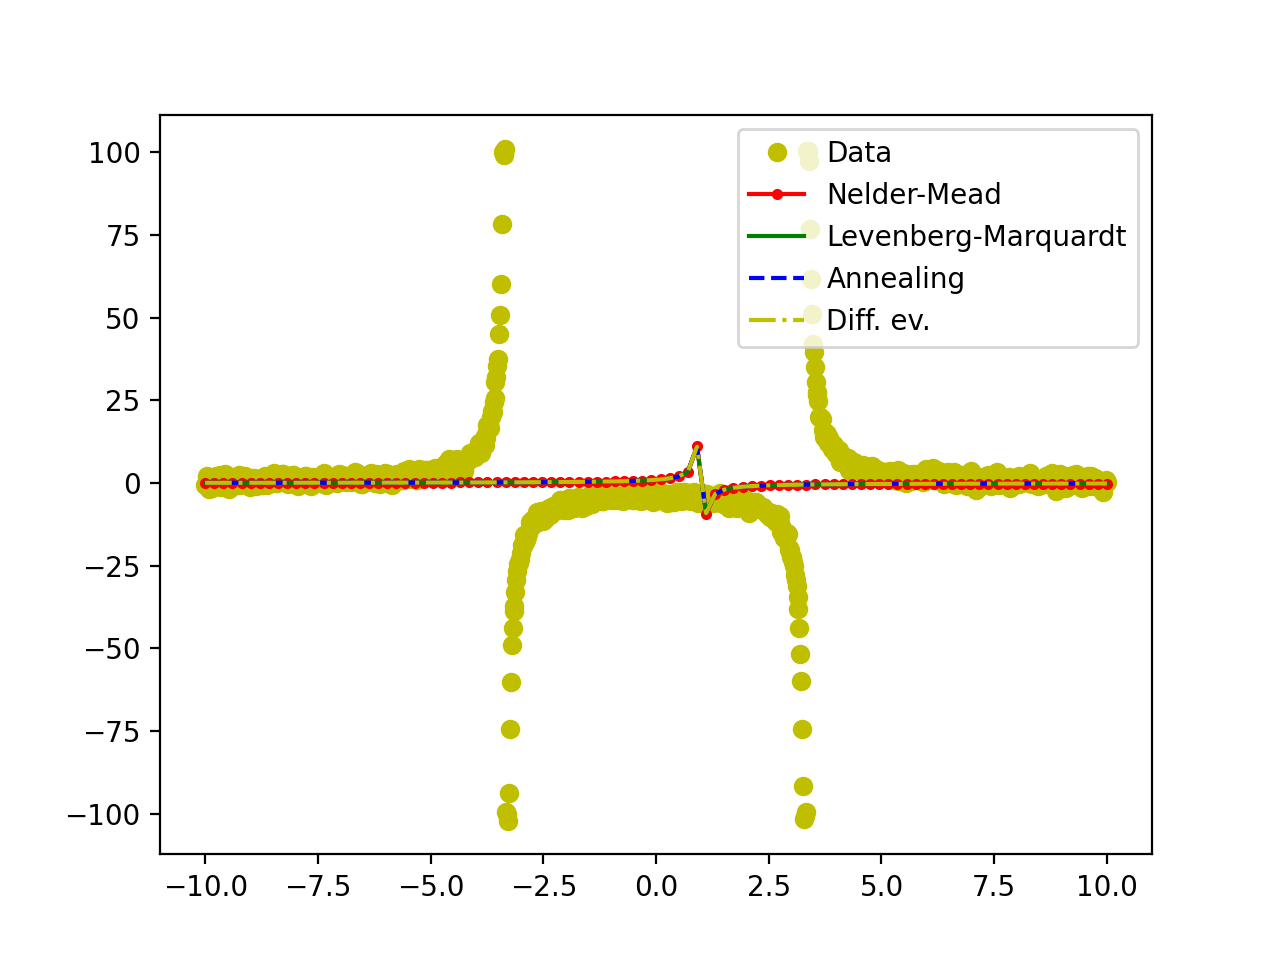

In [15]:
visualize_curves(F, nelder_mead_results, levenberg_marquardt_results, annealing_results, differential_evolution_results)

<IPython.core.display.Javascript object>


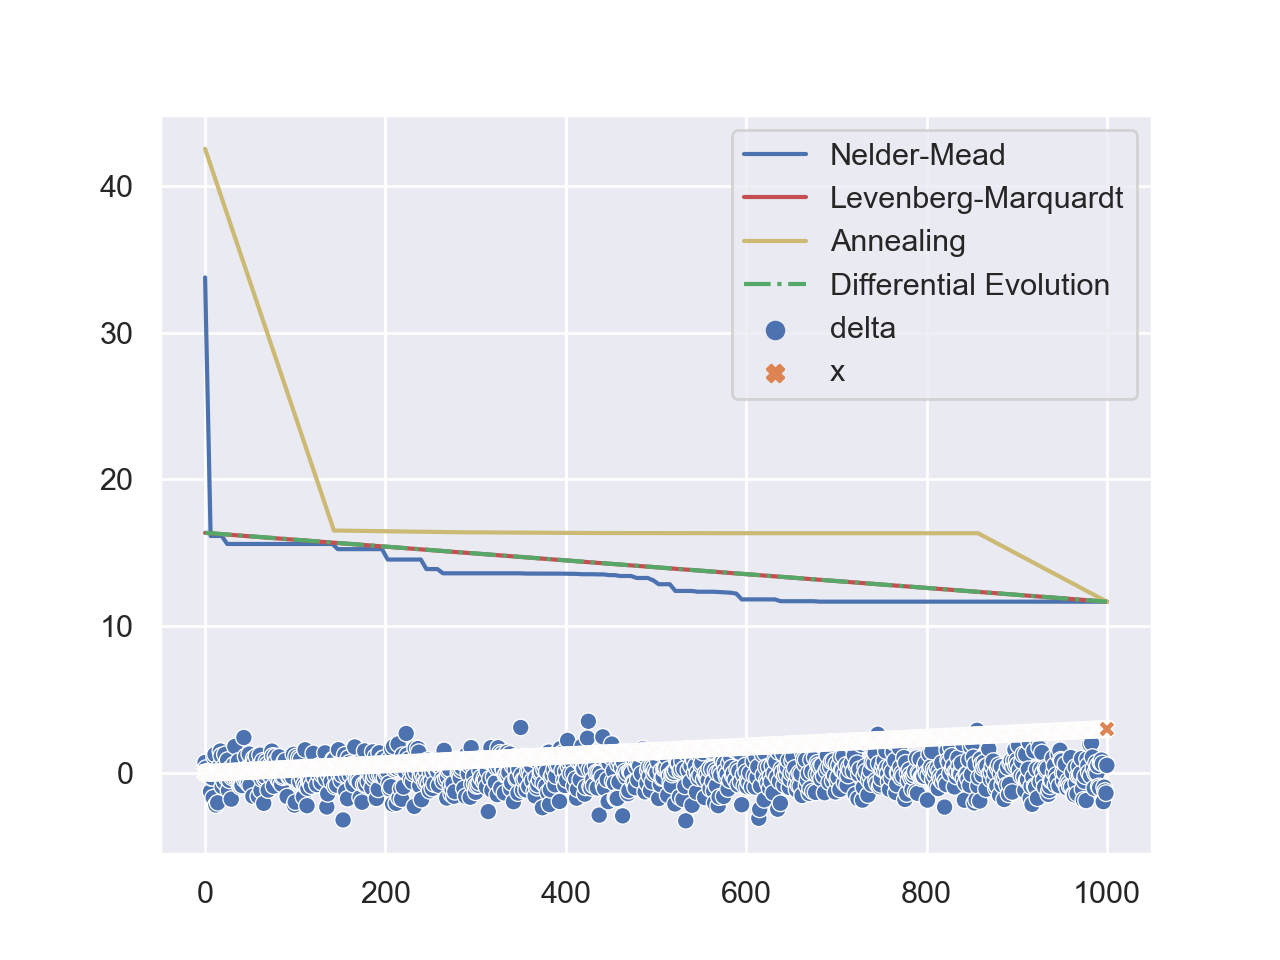

In [72]:
plt.plot(np.linspace(0,1000, len(nelder_mead_results.allvecs)), \
         [math.sqrt(least_squares(vec, F) / 1000) for vec in nelder_mead_results.allvecs],\
         label='Nelder-Mead')
plt.legend()

In [73]:
plt.plot([0, 1000], \
         [math.sqrt(least_squares([0,1,2,3], F) / 1000), 
            math.sqrt(least_squares(levenberg_marquardt_results.x, F) / 1000)],\
        'r-', label='Levenberg-Marquardt')
plt.legend()
levenberg_marquardt_results.x

array([-1.00692533,  1.00739078, -2.00082301,  1.00083952])

In [74]:
plt.plot(np.linspace(0,1000, len(annealings)), \
         [math.sqrt(least_squares(vec, F) / 1000) for vec in annealings],\
         'y-',\
         label='Annealing')
plt.legend()

In [75]:
plt.plot([0, 1000], \
         [math.sqrt(least_squares([1,2,3,4], F) / 1000), 
            math.sqrt(least_squares(differential_evolution_results.x, F) / 1000)],\
        'g-.', label='Differential Evolution')
plt.legend()

In [28]:
df = DataFrame.from_records([["Nelder-Mead", nelder_mead_results.nit, nelder_mead_results.nfev, math.sqrt(least_squares(nelder_mead_results.x, F) / 1000)],\
                             ["Levenberg-Marquardt", '-', levenberg_marquardt_results.nfev, math.sqrt(least_squares(levenberg_marquardt_results.x, F) / 1000)],\
                             ["Annealing", annealing_results.nit, annealing_results.nfev, math.sqrt(least_squares(annealing_results.x, F) / 1000)],\
                             ["Differential Evolution", differential_evolution_results.nit, differential_evolution_results.nfev, math.sqrt(least_squares(differential_evolution_results.x, F) / 1000)]],
                           columns = ['Method', 'Iterations', 'Calls', 'Minimum'])
display(df)

,Method,Iterations,Calls,Minimum
0,Nelder-Mead,164,283,11.672191
1,Levenberg-Marquardt,-,196,11.671099
2,Annealing,1000,9016,11.670837
3,Differential Evolution,4,1100,11.670837


In [147]:
levenberg_marquardt_results.keys()

dict_keys(['x', 'cost', 'fun', 'jac', 'grad', 'optimality', 'active_mask', 'nfev', 'njev', 'status', 'message', 'success'])

## Travelling salesman problem
### Annealing

In [65]:
CITIES_PATH = 'distances_matrix.csv'
COORDS_PATH = 'coords.csv'

In [67]:
cities_df = pd.read_csv(CITIES_PATH, sep=' ', header=None)

coords = pd.read_csv(COORDS_PATH, sep=';', header=None).to_numpy()
cities = np.array([col[:15] for col in cities_df.to_numpy()[:15]])

In [6]:
display(DataFrame(cities, columns = [str(gh) for gh in range(15)]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,681,335,725,1215,657,210,1325,372,227,33,121,1175,1371,697
1,681,0,675,152,1537,1080,886,1494,694,454,700,560,810,1435,892
2,335,675,0,827,1547,405,364,1660,704,518,355,412,1422,1689,1032
3,725,152,827,0,1470,1232,930,1373,657,498,744,604,658,1294,825
4,1215,1537,1547,1470,0,1825,1378,580,843,1136,1192,1172,1172,681,672
5,657,1080,405,1232,1825,0,447,1949,982,879,633,773,1827,1995,1321
6,210,886,364,930,1378,447,0,1502,535,432,186,326,1380,1548,874
7,1325,1494,1660,1373,580,1949,1502,0,967,1204,1316,1268,885,101,628
8,372,694,704,657,843,982,535,967,0,293,349,329,937,1013,339
9,227,454,518,498,1136,879,432,1204,293,0,246,106,983,1213,576


<IPython.core.display.Javascript object>


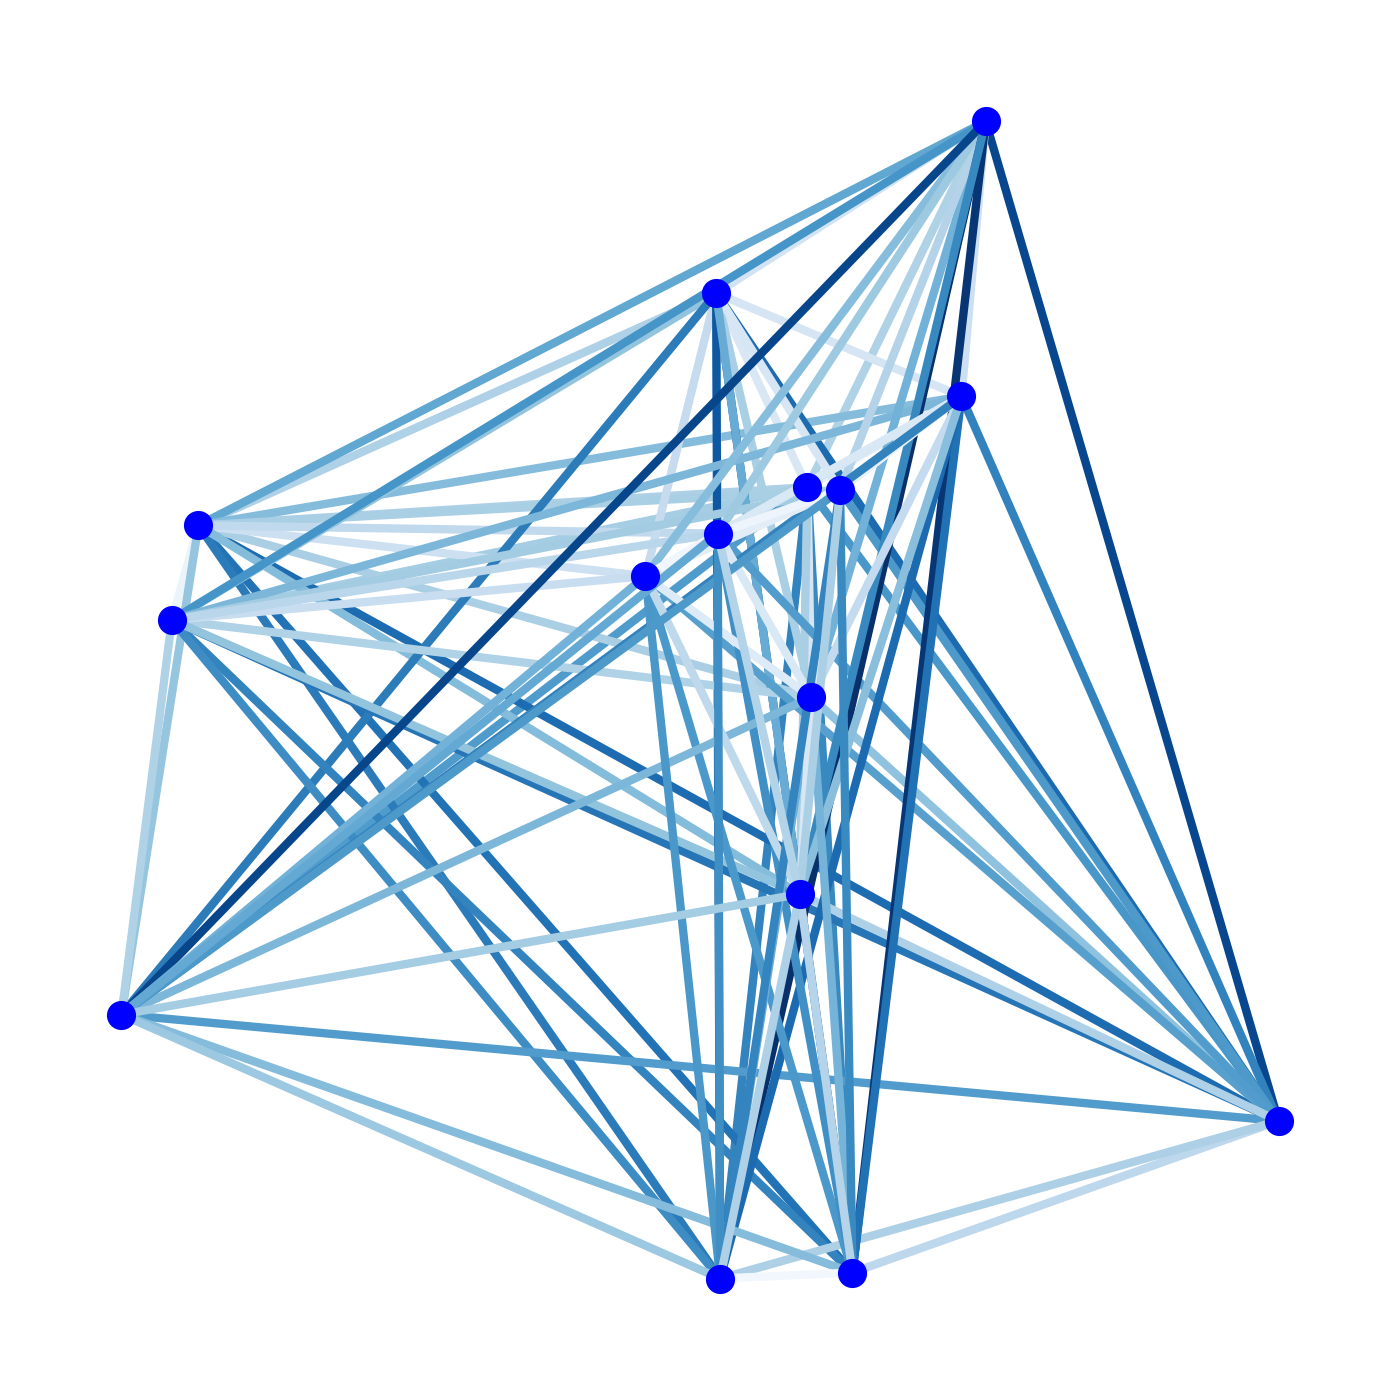

In [70]:
G = nx.Graph()
G.add_nodes_from(range(15))

distances = [_d for _d in np.concatenate(cities) if _d > 0]
min_dist_cities = min(distances)
range_dist_cities = max(distances) - min_dist_cities

for i in range(len(cities)): 
    for j in range(len(cities)): 
        if i == j:
            continue
        ew = (cities[i][j] - min_dist_cities) / range_dist_cities * 10
        G.add_edge(i, j, weight=ew, data=True)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
positions = nx.spring_layout(G, pos={i: val for i, val in enumerate(coords[:15])}, fixed=range(15))
plt.figure(figsize=(7,7))
nx.draw(G, node_size=90, pos = positions, node_color='b', edgelist=edges, edge_color=weights, width=3, edge_cmap=plt.cm.Blues) 
plt.show()

In [93]:
def salesman_annealing(input_matrix):
    next_temp = lambda x: int(x * 0.9)
    coin = lambda: np_rnd.randint(100) > 49
    shift = lambda arr, n: list(arr[-n:]) + list(arr[:-n])
    path_length = lambda p: sum([input_matrix[p[i-1 if i>0 else -1]][val] for i, val in enumerate(p)])
    uniform_rnd = lambda: np_rnd.uniform(0, 0.1, 1)[0]
    
    cities_n = len(input_matrix)
    max_level_checks, required_level_improvements = cities_n * 100, cities_n * 10
    current_checks, current_improvements = max_level_checks, required_level_improvements
    
    temperature = cities_n
    path = list(range(cities_n))
    path_len = path_length(path)
    
    while current_improvements >= required_level_improvements:
        current_checks, current_improvements = 0, 0
        temperature = next_temp(temperature)
        
        while current_checks < max_level_checks \
            and current_improvements < required_level_improvements:
            start_index = np_rnd.randint(len(path))
            new_path = shift(path, -start_index)
            
            if coin():
                # reverse segment
                new_path = new_path[temperature-1::-1] + new_path[temperature:]
                new_path = shift(new_path, start_index)
            else:
                # transpose segment
                sliced, reminder = new_path[:temperature], new_path[temperature:]
                insertion = np_rnd.randint(len(reminder) + 1)
                new_path = shift(reminder[:insertion] + sliced + reminder[insertion:], start_index)
            
            new_path_len = path_length(new_path)
            cost = new_path_len - path_len
            
            if cost < 0 or math.exp(-cost)/(temperature/cities_n) > uniform_rnd():
                path, path_len = new_path, new_path_len
                current_improvements += 1
            
            current_checks += 1
            
    return path

<IPython.core.display.Javascript object>


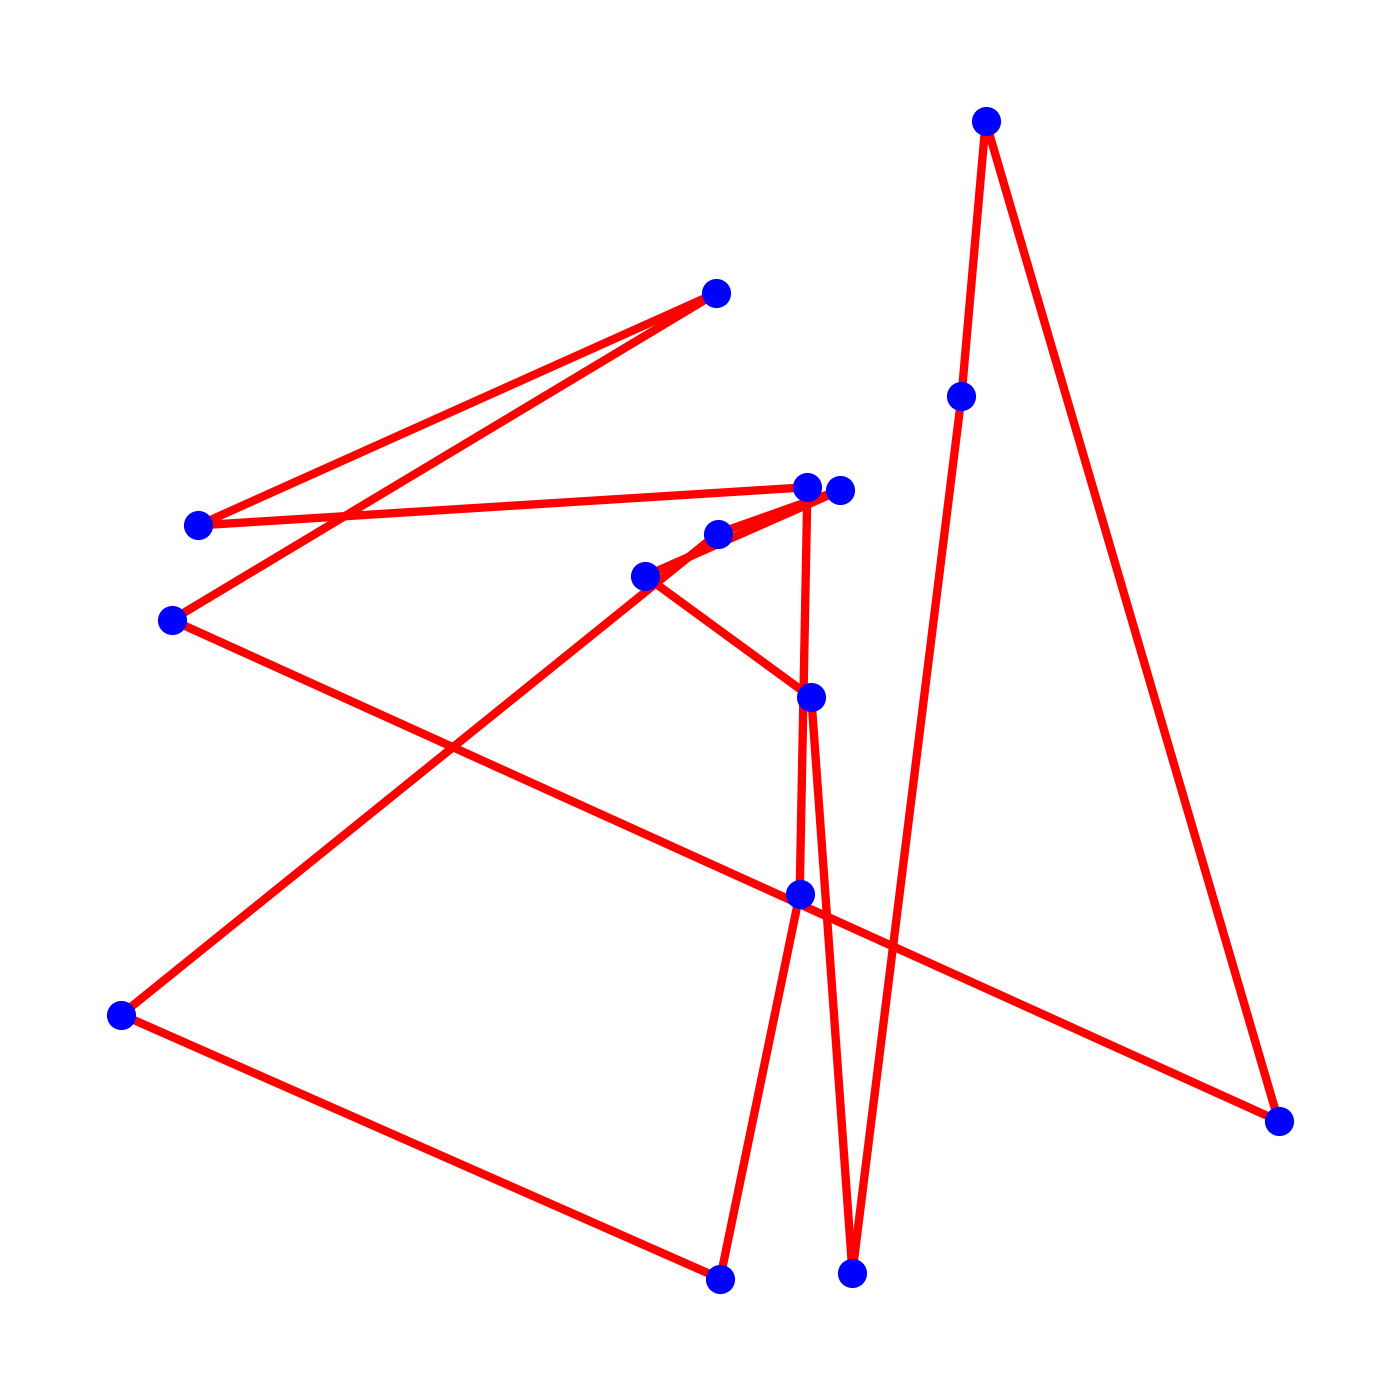

In [94]:
p_len = lambda p: sum([cities[p[i-1 if i>0 else -1]][val] for i, val in enumerate(p)])

def display_path(path):
    length = p_len(path)
    
    pairs = [(path[i-1 if i>0 else -1], val) for i, val in enumerate(path)]
    
    G1 = nx.Graph()
    G1.add_nodes_from(range(15))

    for i in range(len(cities)): 
        for j in range(len(cities)): 
            if i == j:
                continue
            if (i,j) in pairs or (j,i) in pairs:
                G1.add_edge(i, j, color='r')
            else:
                pass#G1.add_edge(i, j, color='b', alpha=0)

    
    positions = nx.spring_layout(G1, pos={i: val for i, val in enumerate(coords[:15])}, fixed=range(15))
    plt.figure(figsize=(7,7))
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    nx.draw(G1, node_size=90, pos = positions, node_color='b', width=3, edge_color=colors)
    plt.title(f'Initial path. Length: {length}')
    plt.show()

display_path(range(15))

<IPython.core.display.Javascript object>


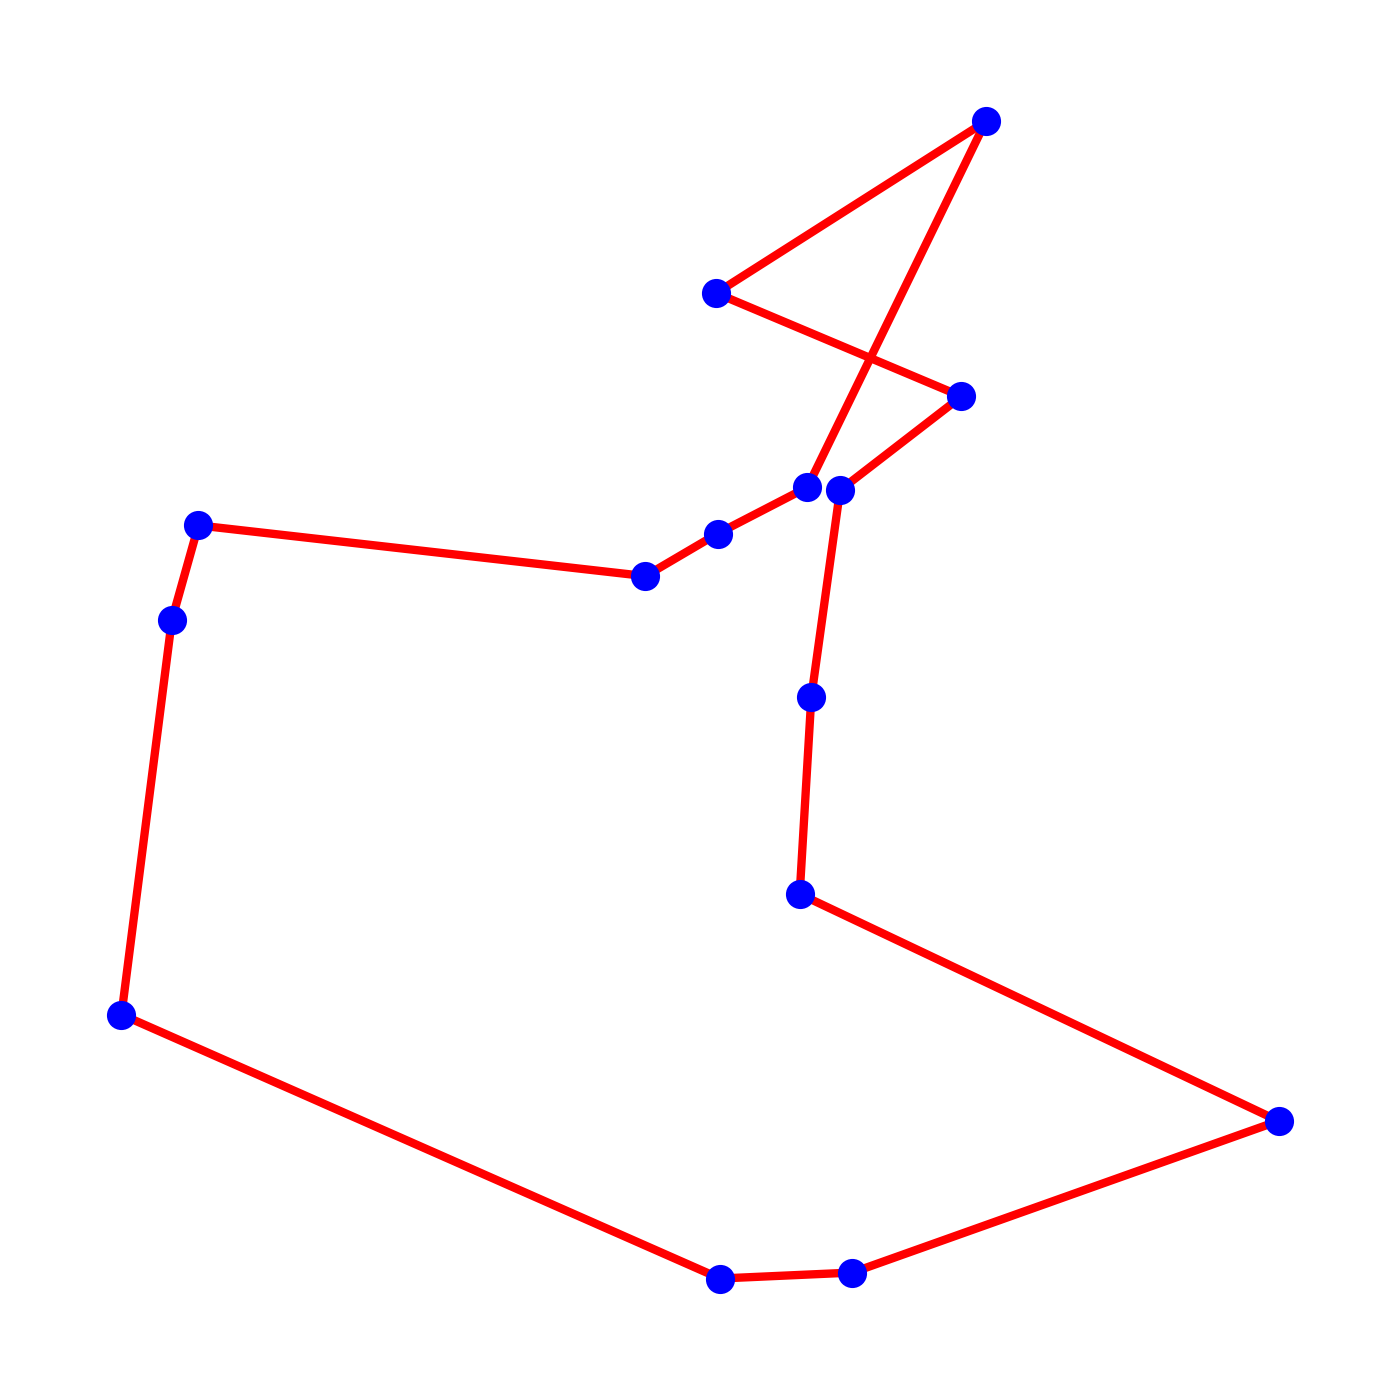

In [102]:
opt = salesman_annealing(cities)
display_path(opt)